# Imports & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import copy
import random
import itertools
from pathlib import Path
from scipy.stats import hmean
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
RAW_DATA_PATH = Path("/home/admin/code/arnaud-odet/7_PhD/Roster/raw_data")
PREPROC_DATA_PATH = Path("/home/admin/code/arnaud-odet/7_PhD/Roster/preproc_data")

sys.path.insert(0, os.path.abspath('..'))
from roster_lib.data.season import Season, TEAM_IDENTIFICATION_COL, OPPONENT_IDENTIFICATION_COL, TEAM_COL_FOULS, OPPONENT_COL_FOULS
from roster_lib.data.period import Period
from roster_lib.utils.plots import plot_logistic_decision_boundary_2d

%reload_ext autoreload
%autoreload 2

In [2]:
kw_success_plot = {'style' : 'csf' ,'hue':'win_rate','palette': 'coolwarm', 'markers' :{1:'o',0:'X'}}


# Period class

In [3]:
period = Period(2015,2019)
ludf = period.data.copy()
trdf = period.transitions.copy()

# EDA

### Data quality check

In [4]:
ludf['n_pl'] = [len(item.split('_')) for item in ludf['lineup']]
ludf.groupby('n_pl').agg({'lineup':'count', 'time':'sum'})

,lineup,time
n_pl,,
5,68160,34664400


In [5]:
import pickle

bad_changes = []
for file in os.listdir(PREPROC_DATA_PATH / 'stats'):
    if file[:11] == 'bad_changes' :
        with open(PREPROC_DATA_PATH / 'stats' / file, 'rb') as f:
            content = pickle.load(f)
        bad_changes += content
pd.DataFrame(bad_changes)

""


In [6]:
ludf[ludf['n_pl'] != 5]

,id,lineup,time,pm,pm_per_48min,team,year,win_rate,csf,0,...,4,relative_time,rk_0,rk_1,rk_2,rk_3,rk_4,rk_id,use_id,n_pl


In [7]:
mask = [x != 5 for x in [len(set(item)) for item in ludf[[str(n) for n in range(5)]].values]] 
ludf[mask]

,id,lineup,time,pm,pm_per_48min,team,year,win_rate,csf,0,...,4,relative_time,rk_0,rk_1,rk_2,rk_3,rk_4,rk_id,use_id,n_pl


In [8]:
duplicated_pl_lus = ludf[mask]['id'].tolist()
duplicated_pl_lus

[]

In [9]:
max([int(txt.split('_')[-1])for txt in ludf['id']])

794

In [10]:
# Checking if identical display names refer to different players

ludf_display = ludf.copy()
for i in range(5):
    ludf_display[str(i)] = [x.split(' - ')[0] for x in ludf_display[str(i)]]

mask_display = [x != 5 for x in [len(set(item)) for item in ludf_display[[str(n) for n in range(5)]].values]]
ludf[mask_display].sort_values('time', ascending=False).head(5)

,id,lineup,time,pm,pm_per_48min,team,year,win_rate,csf,0,...,4,relative_time,rk_0,rk_1,rk_2,rk_3,rk_4,rk_id,use_id,n_pl
7572,MEM_2015_018,B. Udrih - udrihbe01_B. Wright - wrighbr03_J. ...,1898,-8,-12.139094,MEM,2015,0.671,1,B. Udrih - udrihbe01,...,M. Barnes - barnema02,0.007976,1,6,8,19,21,1_6_8_19_21,18,5
7575,MEM_2015_021,J. Green - greenja01_J. Green - greenje02_M. C...,1764,-10,-16.326531,MEM,2015,0.671,1,J. Green - greenja01,...,T. Allen - allento01,0.007413,3,4,5,6,8,3_4_5_6_8,21,5
60002,MEM_2019_022,B. Clarke - clarkbr01_D. Melton - meltode01_J....,1615,18,32.099071,MEM,2019,0.402,0,B. Clarke - clarkbr01,...,T. Jones - jonesty01,0.007557,4,6,8,9,13,4_6_8_9_13,22,5
7587,MEM_2015_033,J. Green - greenja01_J. Green - greenje02_M. B...,1285,-9,-20.171206,MEM,2015,0.671,1,J. Green - greenja01,...,Z. Randolph - randoza01,0.005400,1,2,6,8,9,1_2_6_8_9,33,5
12798,CLE_2016_040,D. Williams - willide01_D. Williams - willide0...,1125,2,5.120000,CLE,2016,0.695,1,D. Williams - willide01,...,R. Jefferson - jefferi01,0.004716,1,6,9,11,12,1_6_9_11_12,40,5


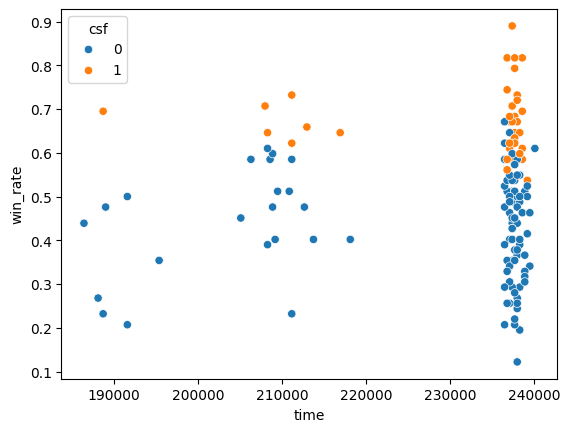

In [11]:
sns.scatterplot(ludf.groupby(['team','year']).agg({'time':'sum'}).merge(period.success, left_index = True, right_index=True),
                x = 'time',
                y='win_rate',
                hue = 'csf');

In [12]:
ludf.drop(columns = 'n_pl',inplace=True)

### Transitions

In [13]:
trdf.sort_values('lu_cosine',ascending=False)

,,lu_cosine,pl_cosine,jaccard,win_rate,delta_win_rate,csf,diversity_index,nondpd_score
team,year,,,,,,,,
GSW,2017,0.814370,0.897739,0.545455,0.817,-0.073,1,3,0.125038
UTA,2018,0.743201,0.877453,0.625000,0.585,-0.037,1,3,0.088237
MIN,2016,0.645857,0.908455,0.391304,0.354,0.159,0,3,0.076058
POR,2018,0.645063,0.829414,0.478261,0.598,0.098,0,4,0.125695
DEN,2019,0.644029,0.847611,0.392857,0.659,0.098,1,3,0.110514
...,...,...,...,...,...,...,...,...,...
MIL,2016,0.000000,0.576989,0.285714,0.402,-0.098,0,3,0.026022
POR,2019,0.000000,0.475069,0.321429,0.646,0.048,1,3,0.015866
SAC,2017,0.000000,0.336462,0.233333,0.390,-0.012,0,3,0.022817


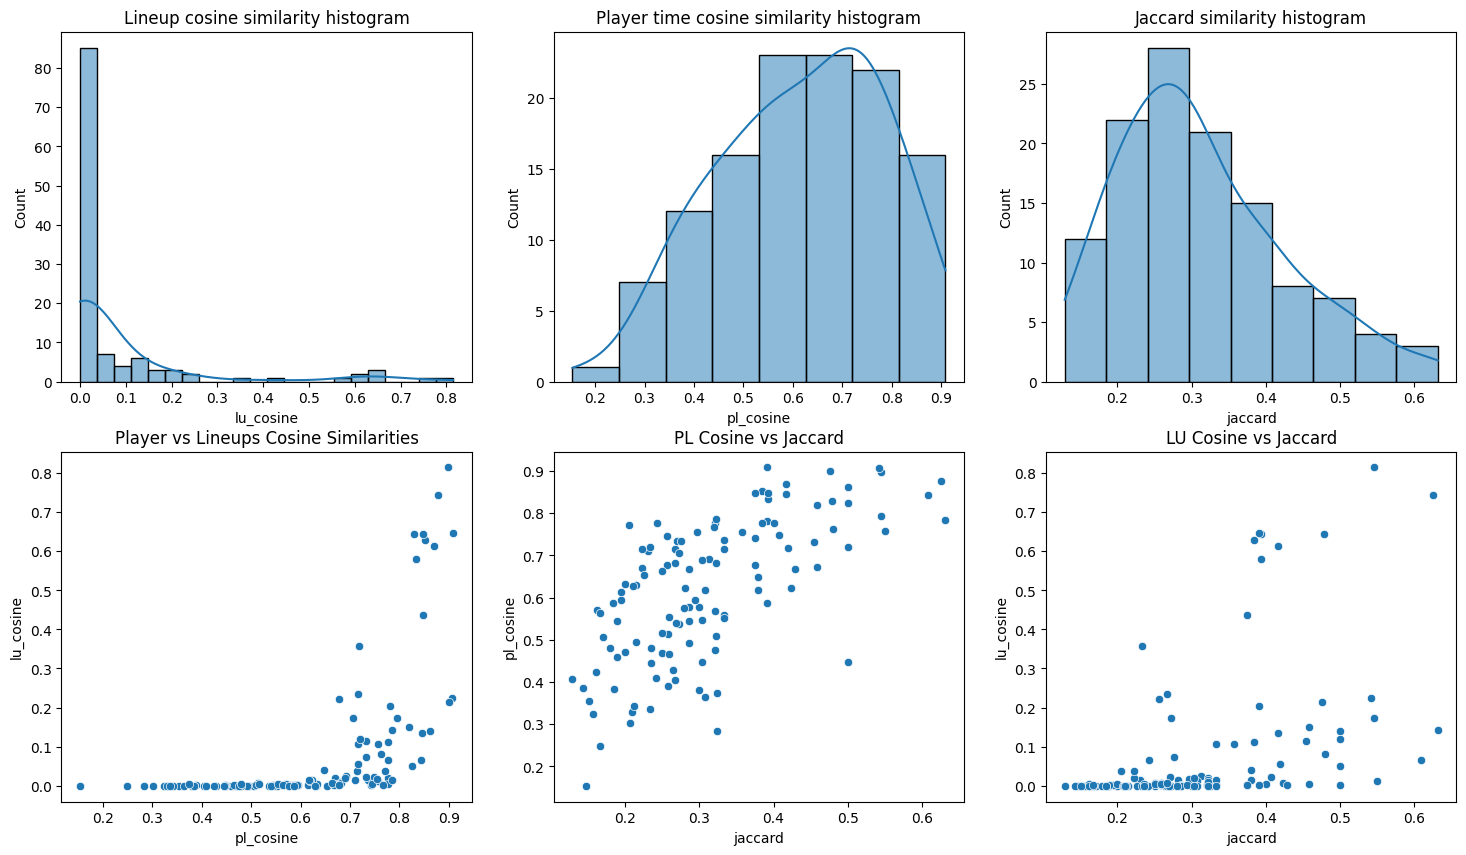

In [14]:
fig, axs = plt.subplots(2,3, figsize = (18,10));
sns.histplot(data = trdf, x = 'lu_cosine', kde = True, ax=axs[0,0]);
axs[0,0].set_title("Lineup cosine similarity histogram");
sns.histplot(data = trdf, x = 'pl_cosine', kde = True, ax=axs[0,1]);
axs[0,1].set_title("Player time cosine similarity histogram");
sns.histplot(data = trdf, x = 'jaccard', kde = True, ax=axs[0,2]);
axs[0,2].set_title("Jaccard similarity histogram");
sns.scatterplot(data = trdf, x = 'pl_cosine',y= 'lu_cosine', ax=axs[1,0]);
axs[1,0].set_title("Player vs Lineups Cosine Similarities");
sns.scatterplot(data = trdf, x = 'jaccard',y= 'pl_cosine', ax=axs[1,1]);
axs[1,1].set_title("PL Cosine vs Jaccard");
sns.scatterplot(data = trdf, x = 'jaccard',y= 'lu_cosine', ax=axs[1,2]);
axs[1,2].set_title("LU Cosine vs Jaccard");


In [15]:
# Insvestigate transition
tm = 'POR'
yr = 2019

_viz_df = ludf[(ludf['team']==tm)&(ludf['year'].isin([yr-1,yr]))].pivot(index = 'lineup',columns = 'year', values = 'time')
_viz_df['total'] = _viz_df.sum(axis = 1)
display(_viz_df[_viz_df[[yr-1,yr]].isna().any(axis = 1)==False].sort_values('total', ascending = False).head(5))
_viz_df.sort_values('total', ascending = False).head(20)

year,2018,2019,total
lineup,,,


year,2018,2019,total
lineup,,,
A. Aminu - aminual01_C. McCollum - mccolcj01_D. Lillard - lillada01_J. Nurkić - nurkiju01_M. Harkless - harklma01,44618.0,NaN,44618.0
A. Aminu - aminual01_C. McCollum - mccolcj01_D. Lillard - lillada01_J. Layman - laymaja01_J. Nurkić - nurkiju01,22121.0,NaN,22121.0
C. Anthony - anthoca01_C. McCollum - mccolcj01_D. Lillard - lillada01_H. Whiteside - whiteha01_K. Bazemore - bazemke01,NaN,18895.0,18895.0
A. Aminu - aminual01_C. McCollum - mccolcj01_D. Lillard - lillada01_E. Turner - turneev01_J. Nurkić - nurkiju01,15616.0,NaN,15616.0
C. Anthony - anthoca01_C. McCollum - mccolcj01_D. Lillard - lillada01_H. Whiteside - whiteha01_T. Ariza - arizatr01,NaN,13745.0,13745.0
E. Turner - turneev01_M. Leonard - leoname01_N. Stauskas - stausni01_S. Curry - curryse01_Z. Collins - colliza01,11753.0,NaN,11753.0
C. Anthony - anthoca01_C. McCollum - mccolcj01_G. Trent - trentga02_H. Whiteside - whiteha01_T. Ariza - arizatr01,NaN,8271.0,8271.0
C. Anthony - anthoca01_C. McCollum - mccolcj01_D. Lillard - lillada01_H. Whiteside - whiteha01_R. Hood - hoodro01,NaN,5607.0,5607.0
C. Anthony - anthoca01_C. McCollum - mccolcj01_D. Lillard - lillada01_G. Trent - trentga02_J. Nurkić - nurkiju01,NaN,5430.0,5430.0


### Success analysis

In [16]:
success_df = pd.read_csv(PREPROC_DATA_PATH / 'team_success.csv').set_index(['TEAM','YEAR'])

period_success = success_df.reset_index().pivot(index = 'TEAM', columns='YEAR', values = 'win_rate')[[yr for yr in period.period]]
success_std = pd.DataFrame([{tm : period_success.loc[tm].std() for tm in period_success.index}], index = ['std']).T.sort_values('std', ascending = False)
success_std.head(10)

,std
PHI,0.232627
CLE,0.186778
ATL,0.177314
MEM,0.150302
CHI,0.140994
MIN,0.137232
DAL,0.120943
BKN,0.120722
MIL,0.120668
DEN,0.118944


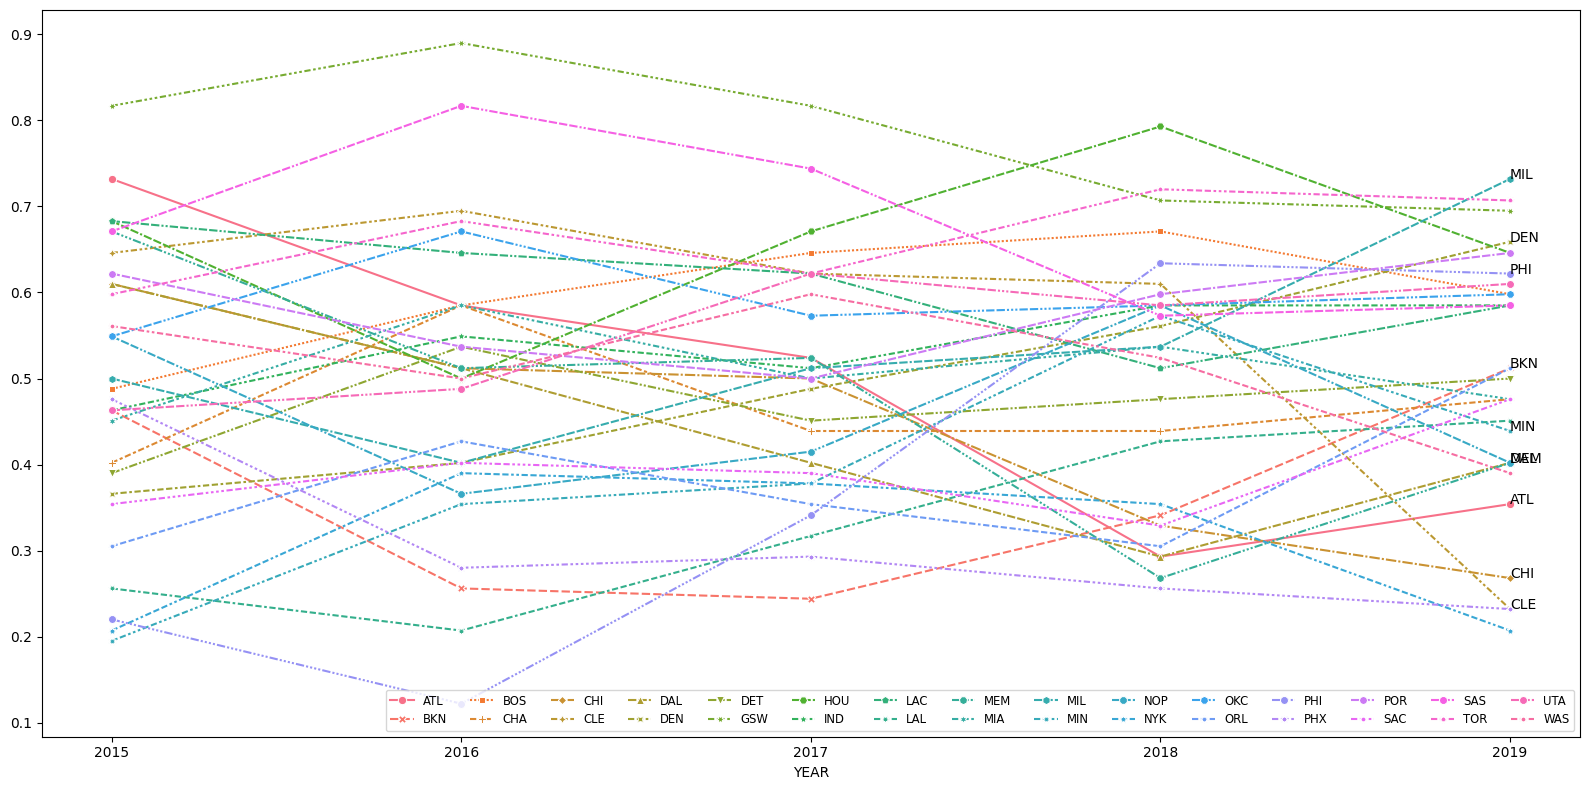

In [17]:
fig, ax = plt.subplots(1,1,figsize = (16,8))
sns.lineplot(period_success.T, ax = ax, markers = True);
plt.legend(ncol=15, loc='lower right', fontsize='small');
for tm in success_std.head(10).index :
    ax.text(period.period[-1], period_success.loc[tm,period.period[-1]],  tm);
ax.set_xticks(period.period)
plt.tight_layout();
plt.show();

# Lineups analysis

### time

##### Co-presence

<span stlye="color:red"> Identify trades !! </span>

In [18]:
non_copr = period.find_non_copresence(9,0)
{k:v for k,v in non_copr.items() if k[-4:] == '2018'}

{'WAS_2018': {'rank_id': [(6, 9), (7, 9), (8, 9)],
  'names': [('O. Porter', 'B. Portis'),
   ('J. Wall', 'B. Portis'),
   ('M. Morris', 'B. Portis')]},
 'PHI_2018': {'rank_id': [(6, 9), (7, 9), (8, 9)],
  'names': [('L. Shamet', 'T. Harris'),
   ('M. Muscala', 'T. Harris'),
   ('W. Chandler', 'T. Harris')]},
 'BKN_2018': {'rank_id': [(3, 6)], 'names': [('J. Allen', 'E. Davis')]},
 'MEM_2018': {'rank_id': [(2, 9), (3, 9), (6, 9), (7, 9), (8, 9)],
  'names': [('M. Gasol', 'D. Wright'),
   ('G. Temple', 'D. Wright'),
   ('K. Anderson', 'D. Wright'),
   ('S. Mack', 'D. Wright'),
   ('J. Green', 'D. Wright')]}}

##### Top_k analysis

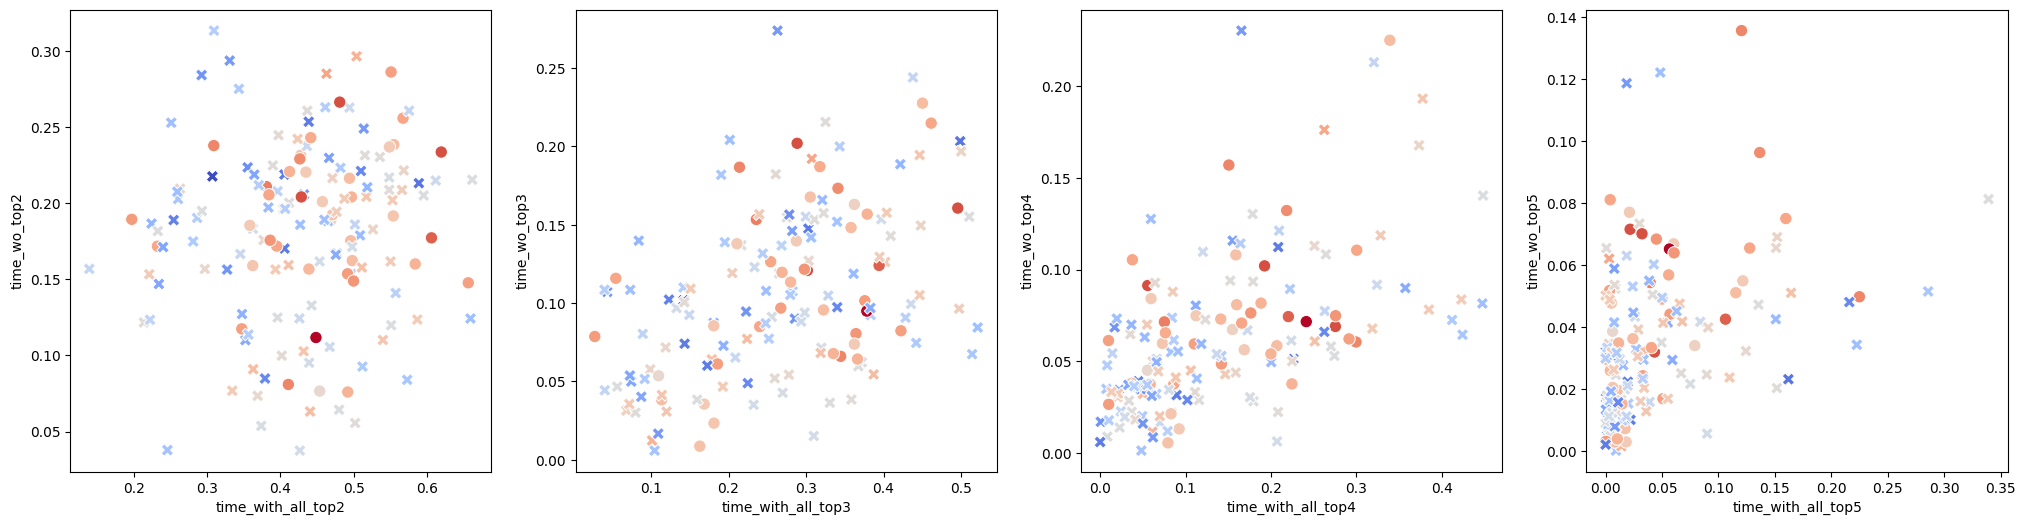

In [19]:
fig, axs = plt.subplots(1,4,figsize = (25,6))
for i,k in enumerate(range(2,6)):
    str_excl = f'time_wo_top{k}'
    str_incl = f'time_with_all_top{k}'
    _df = pd.concat([period.top_players_lineups_rate(top_k = k, exclude= True).rename(columns = {'time_share':str_excl}),
                     period.top_players_lineups_rate(top_k = k).rename(columns = {'time_share':str_incl}),
                     period.success.swaplevel(0)], axis = 1)
    sns.scatterplot(data = _df, x = str_incl, y = str_excl, **kw_success_plot, s =80, legend = False, ax = axs[i]);


In [20]:
top_5_rate = period.top_players_lineups_rate()
top_5_rate[top_5_rate['time_share']==0].index

MultiIndex([(2015, 'UTA'),
            (2018, 'MIN'),
            (2019, 'NOP'),
            (2019, 'NYK')],
           names=['year', 'team'])

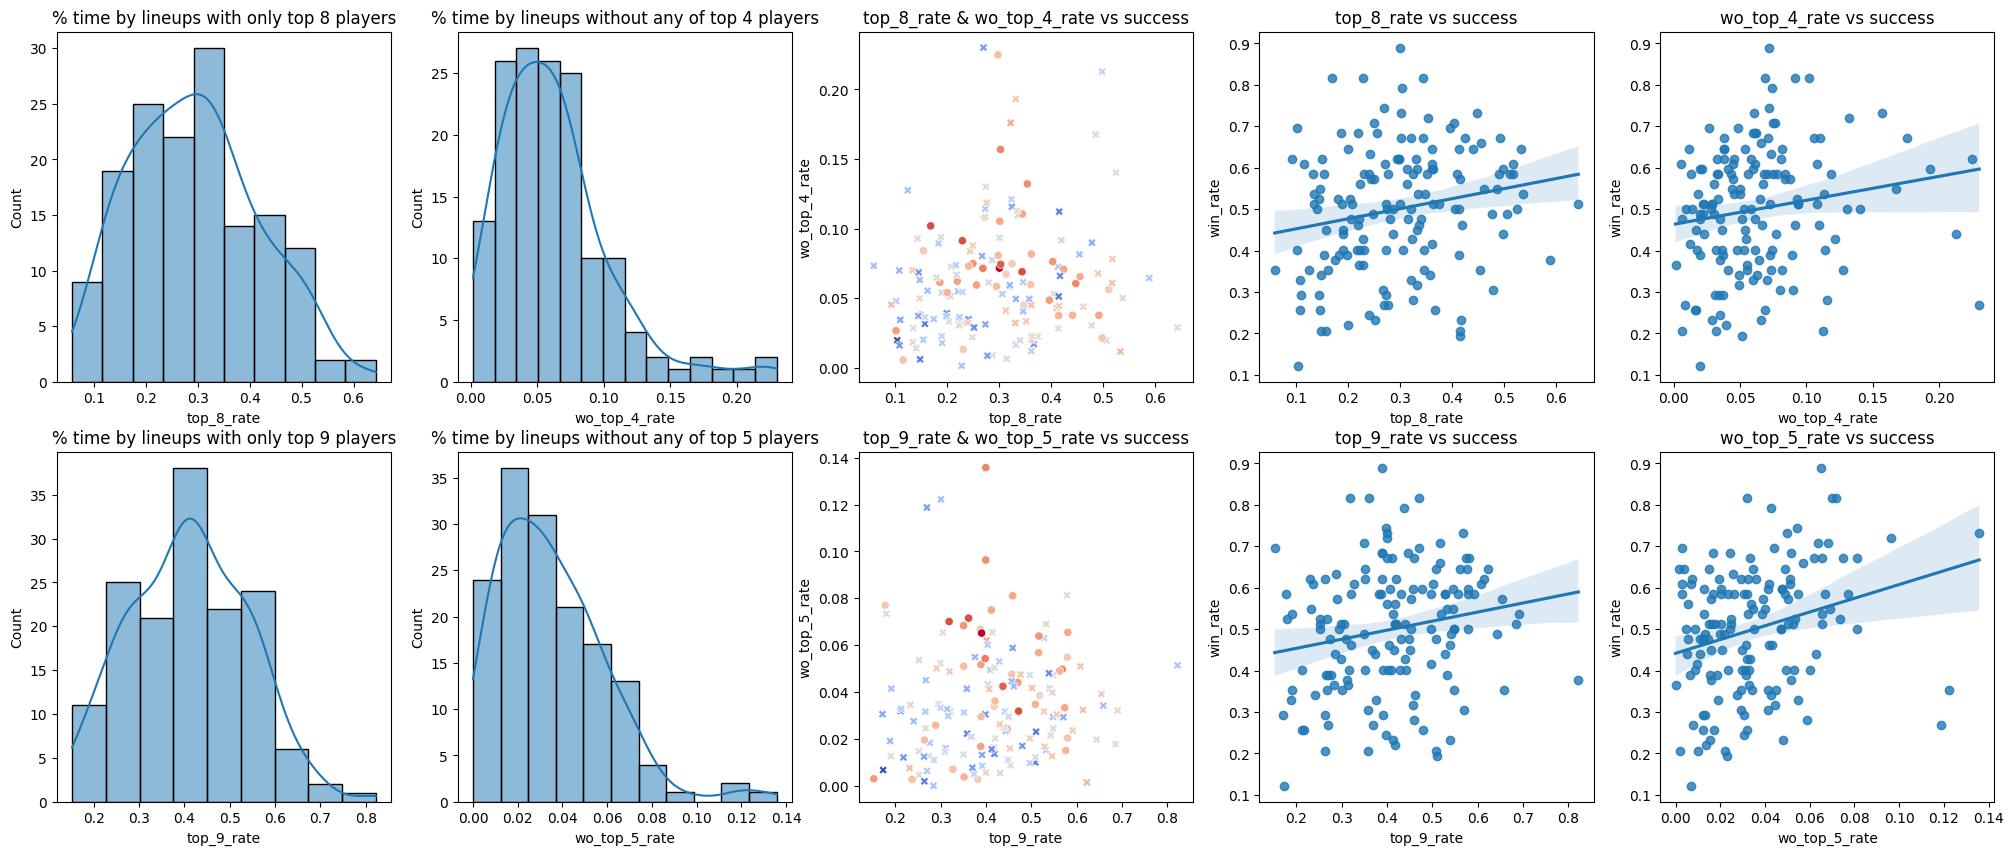

In [21]:
fig, axs = plt.subplots(2,5, figsize = (25,10));
for i, k in enumerate(range(8,10)):
    top_str = f'top_{k}_rate'
    second_str = f'wo_top_{k-4}_rate'
    top = period.top_players_lineups_rate(top_k=k, exclude = False).rename(columns = {'time_share':top_str})
    second_unit = period.top_players_lineups_rate(top_k=k-4, exclude = True).rename(columns = {'time_share':second_str})
    _data = top.merge(second_unit, right_index = True, left_index = True)
    _data = _data.merge(period.success.swaplevel(0), right_index = True, left_index = True)
    sns.histplot(data = _data, x = top_str, kde = True, ax = axs[i,0]);
    axs[i,0].set_title(f"% time by lineups with only top {k} players");
    sns.histplot(data = _data, x = second_str, kde = True, ax = axs[i,1]);
    axs[i,1].set_title(f"% time by lineups without any of top {k-4} players");
    sns.scatterplot(data = _data, x = top_str, y = second_str, **kw_success_plot, ax = axs[i,2], legend = False);
    axs[i,2].set_title(f"{top_str} & {second_str} vs success");
    sns.regplot(data = _data, x = top_str, y = 'win_rate', ax = axs[i,3]);
    axs[i,3].set_title(f"{top_str} vs success");
    sns.regplot(data = _data, x = second_str, y = 'win_rate', ax = axs[i,4]);
    axs[i,4].set_title(f"{second_str} vs success");
    


Optimization terminated successfully.
         Current function value: 0.547078
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  150
Model:                          Logit   Df Residuals:                      147
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                 0.05662
Time:                        09:07:38   Log-Likelihood:                -82.062
converged:                       True   LL-Null:                       -86.987
Covariance Type:            nonrobust   LLR p-value:                  0.007259
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0767      0.195     -5.516      0.000      -1.459      -0.694
top_8_rate        0.

,pred 0,pred 1
true 0,107,3
true 1,38,2


Adjusted model (decision boudary @ p = 0.25) - Accuracy : 0.653, F1 : 0.509


,pred 0,pred 1
true 0,71,39
true 1,13,27


/home/admin/.pyenv/versions/3.13.2/envs/roster_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


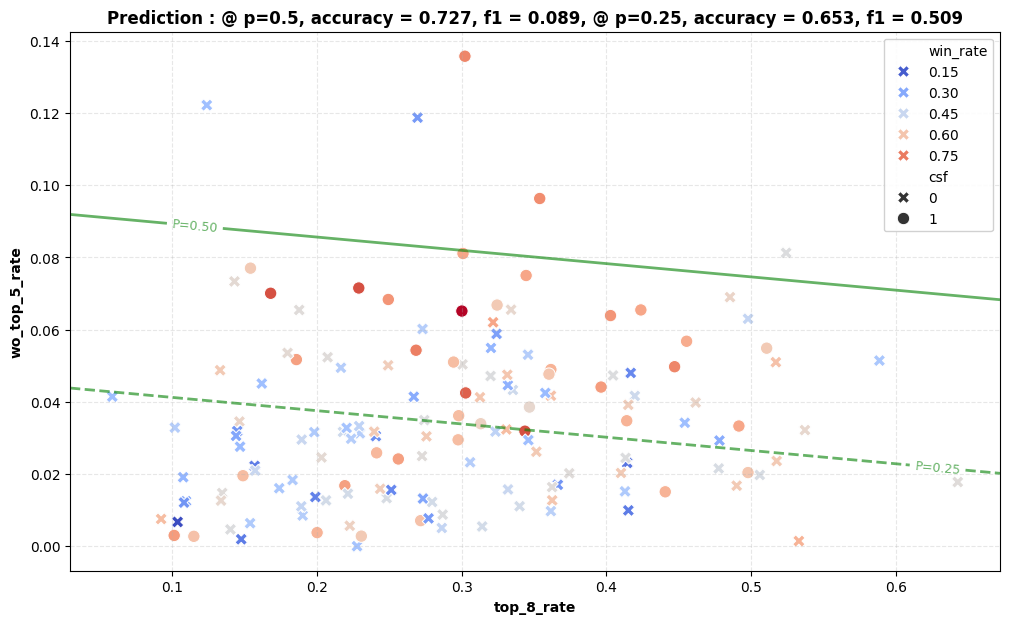

In [22]:
k_top = 8
k_second = 5

top_str = f'top_{k_top}_rate'
second_str = f'wo_top_{k_second}_rate'
top = period.top_players_lineups_rate(top_k=k_top, exclude = False).rename(columns = {'time_share':top_str})
second_unit = period.top_players_lineups_rate(top_k=k_second, exclude = True).rename(columns = {'time_share':second_str})
_data = top.merge(second_unit, right_index = True, left_index = True)
_data = _data.merge(period.success.swaplevel(0), right_index = True, left_index = True)
plot_logistic_decision_boundary_2d(data = _data, x1 = top_str, x2=second_str, y= 'csf', hue_col='win_rate', step = 0.01)

##### Lineup diversity

In [23]:
a = np.array([0.4,0.3,0.2,0.04,0.03,0.02,0.01])
b = np.array([0.8,0.08,0.05,0.04,0.03])

hmean(a[1:] / a[:-1]), hmean(b[1:] / b[:-1])

(np.float64(0.47368421052631576), np.float64(0.282021151586369))

In [24]:
def _diversity_index(period, top_n:int=100, target_share:float = 0.9):
    _df = period.data.copy()
    _df['tm_yr'] = [f"{tm}_{yr}" for tm,yr in zip(_df['team'],_df['year'])]
    success = period.success.copy()
    success.index = [f"{tm}_{yr}" for tm,yr in success.index]
    
    lu_relative_time =  {ind : _df[_df['tm_yr']==ind]['relative_time'].reset_index(drop=True) for ind in _df['tm_yr'].unique()}
    lu_ratio_hmean = pd.Series({k : hmean(v[1:].values / v[:-1].values) for k,v in lu_relative_time.items()}, name = 'ratio_hmean')
    
    lu_topn = pd.Series({k : np.sum(v[:top_n]) for k,v in lu_relative_time.items()}, name = f'top{top_n}_share')
    lu_cumsum = {k : np.cumsum(v) for k,v in lu_relative_time.items()}
    lu_target = pd.Series({k : np.argmax([i if cs < target_share else 0 for i, cs in enumerate(v)])+1 for k,v in lu_cumsum.items()}, name = f'n_lu_top_{target_share}')
    lu_std = pd.Series({k : v.std() for k,v in lu_relative_time.items()}, name = 'lu_share_std')
    lu_target_std = pd.Series({ k : v[:lu_target[k]].std() for k,v in lu_relative_time.items()}, name = f"lu_top_{target_share}_std")
    lu_topn_std = pd.Series({ k : v[:top_n].std() for k,v in lu_relative_time.items()}, name = f"top{top_n}_lu_std")
    
    
    return pd.concat([lu_ratio_hmean,lu_topn,lu_target,lu_std,lu_target_std,lu_topn_std], axis = 1).merge(success, left_index=True, right_index= True)

div_df = _diversity_index(period, top_n = 100, target_share= 0.8)
div_df

,ratio_hmean,top100_share,n_lu_top_0.8,lu_share_std,lu_top_0.8_std,top100_lu_std,win_rate,csf,diversity_index,nondpd_score
ATL_2015,0.966723,0.847617,77,0.012238,0.026197,0.023219,0.732,1,3,0.074498
DET_2015,0.938990,0.941942,38,0.018173,0.039555,0.025839,0.390,0,4,0.046586
CHI_2015,0.979519,0.718205,140,0.004890,0.007747,0.008748,0.610,1,3,0.030627
CLE_2015,0.964442,0.790363,105,0.007923,0.014100,0.014392,0.646,1,4,0.106198
GSW_2015,0.967154,0.834943,83,0.008954,0.017570,0.016241,0.817,1,3,0.083646
...,...,...,...,...,...,...,...,...,...,...
DEN_2019,0.966595,0.841979,78,0.011552,0.024056,0.021490,0.659,1,3,0.110514
ATL_2019,0.984907,0.589292,254,0.003450,0.005375,0.007816,0.354,0,2,0.086716
HOU_2019,0.970923,0.749189,127,0.006915,0.011374,0.012565,0.646,1,3,0.042339
MIL_2019,0.981439,0.607208,229,0.005305,0.008643,0.012648,0.732,1,2,0.196108


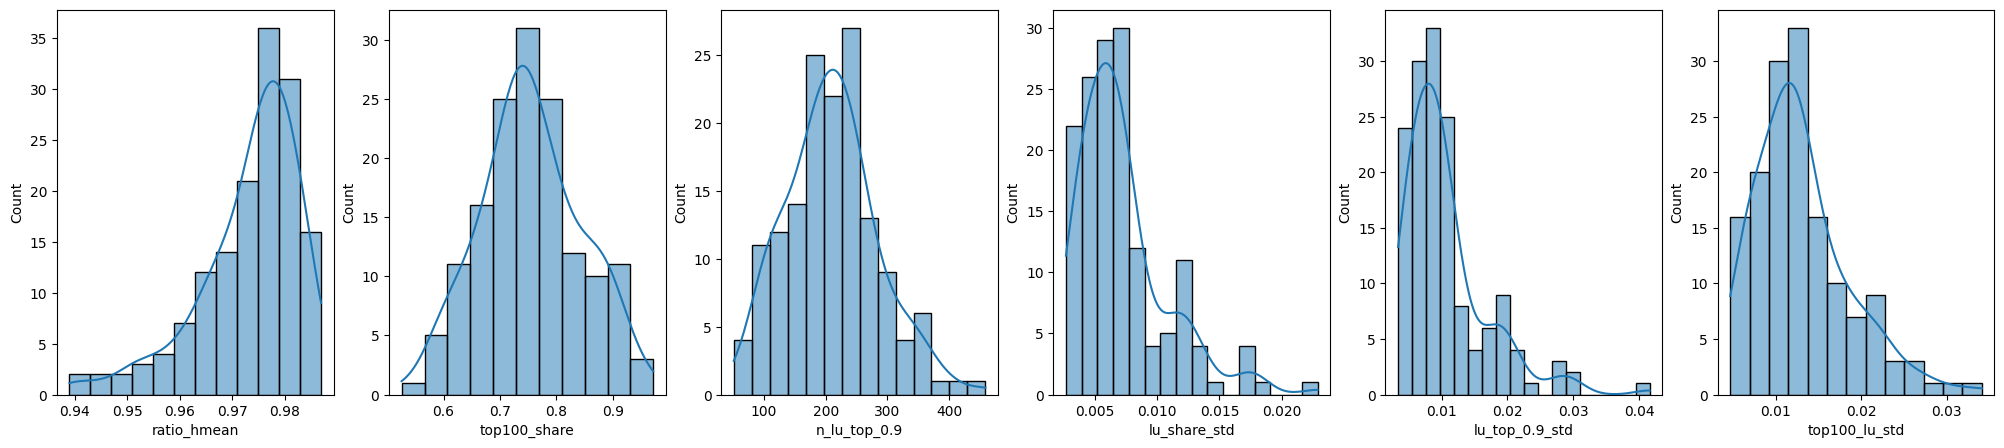

In [25]:
div_df = _diversity_index(period, top_n = 100, target_share= 0.9)

fig, axs = plt.subplots(1,6, figsize = (25,5))
for k in range(6):
    sns.histplot(data = div_df, x = div_df.columns[k], kde = True, ax = axs[k]);


In [26]:
div_df

,ratio_hmean,top100_share,n_lu_top_0.9,lu_share_std,lu_top_0.9_std,top100_lu_std,win_rate,csf,diversity_index,nondpd_score
ATL_2015,0.966723,0.847617,140,0.012238,0.019864,0.023219,0.732,1,3,0.074498
DET_2015,0.938990,0.941942,70,0.018173,0.030307,0.025839,0.390,0,4,0.046586
CHI_2015,0.979519,0.718205,219,0.004890,0.006544,0.008748,0.610,1,3,0.030627
CLE_2015,0.964442,0.790363,174,0.007923,0.011346,0.014392,0.646,1,4,0.106198
GSW_2015,0.967154,0.834943,145,0.008954,0.013845,0.016241,0.817,1,3,0.083646
...,...,...,...,...,...,...,...,...,...,...
DEN_2019,0.966595,0.841979,142,0.011552,0.018295,0.021490,0.659,1,3,0.110514
ATL_2019,0.984907,0.589292,388,0.003450,0.004493,0.007816,0.354,0,2,0.086716
HOU_2019,0.970923,0.749189,203,0.006915,0.009305,0.012565,0.646,1,3,0.042339
MIL_2019,0.981439,0.607208,346,0.005305,0.007136,0.012648,0.732,1,2,0.196108


Optimization terminated successfully.
         Current function value: 0.558757
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  150
Model:                          Logit   Df Residuals:                      147
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                 0.03648
Time:                        09:07:39   Log-Likelihood:                -83.814
converged:                       True   LL-Null:                       -86.987
Covariance Type:            nonrobust   LLR p-value:                   0.04185
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.0564      0.192     -5.507      0.000      -1.432      -0.680
ratio_hmean      0.1781

,pred 0,pred 1
true 0,108,2
true 1,39,1


Adjusted model (decision boudary @ p = 0.27) - Accuracy : 0.660, F1 : 0.495


,pred 0,pred 1
true 0,74,36
true 1,15,25


/home/admin/.pyenv/versions/3.13.2/envs/roster_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


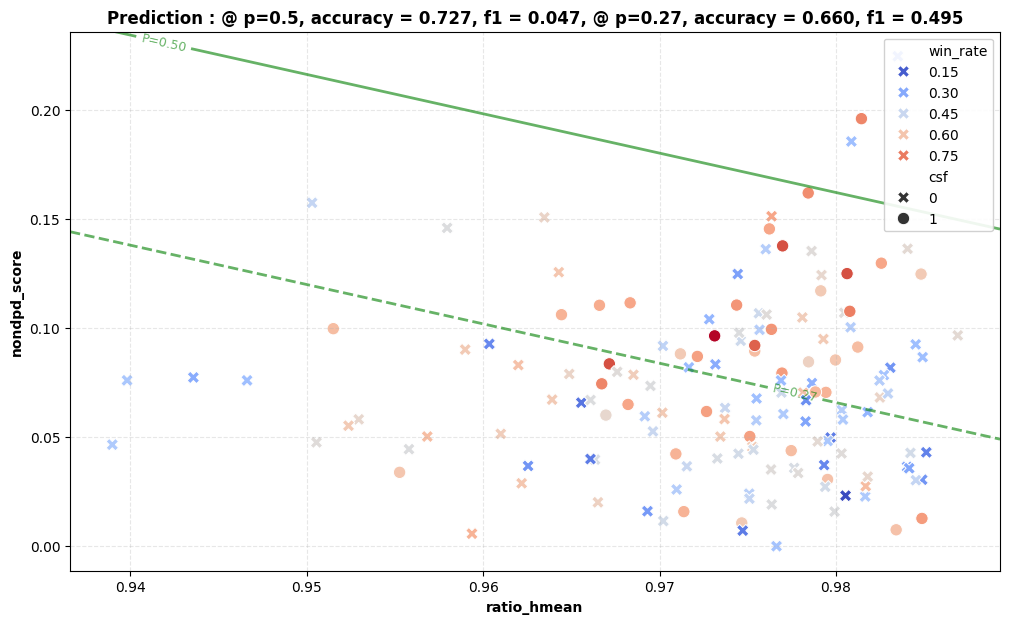

In [27]:
plot_logistic_decision_boundary_2d(data = div_df, x1 = 'ratio_hmean', x2='nondpd_score', y= 'csf', hue_col='win_rate', step = 0.01)

Optimization terminated successfully.
         Current function value: 0.572274
         Iterations 5


/home/admin/.pyenv/versions/3.13.2/envs/roster_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


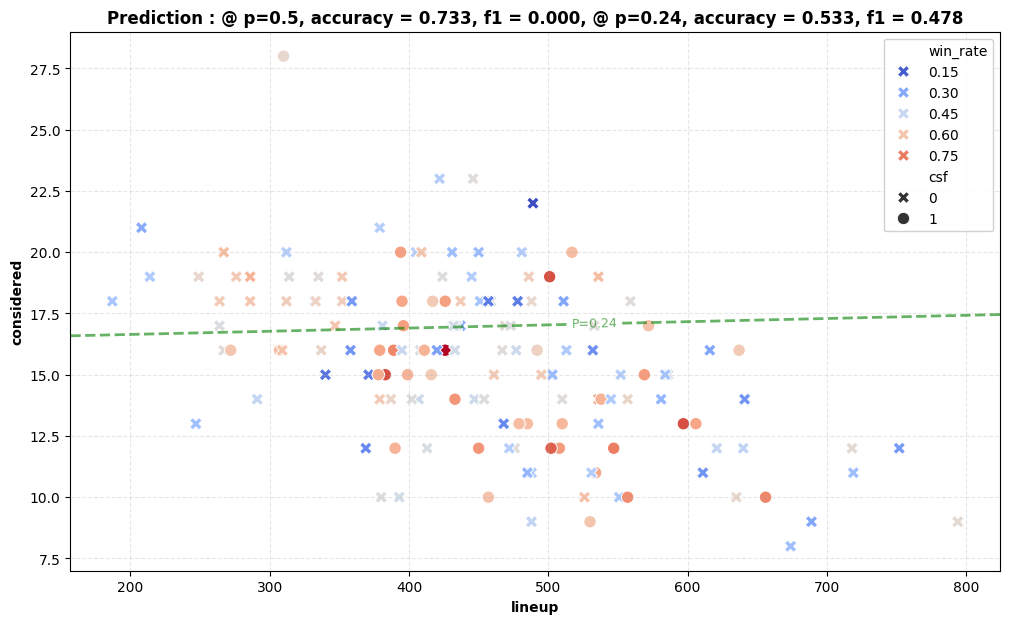

In [28]:
period.diversity_plot(threshold = 0.01, step=0.02, show_confusion_matrices=False, show_summary=False)


##### Non-dependance index

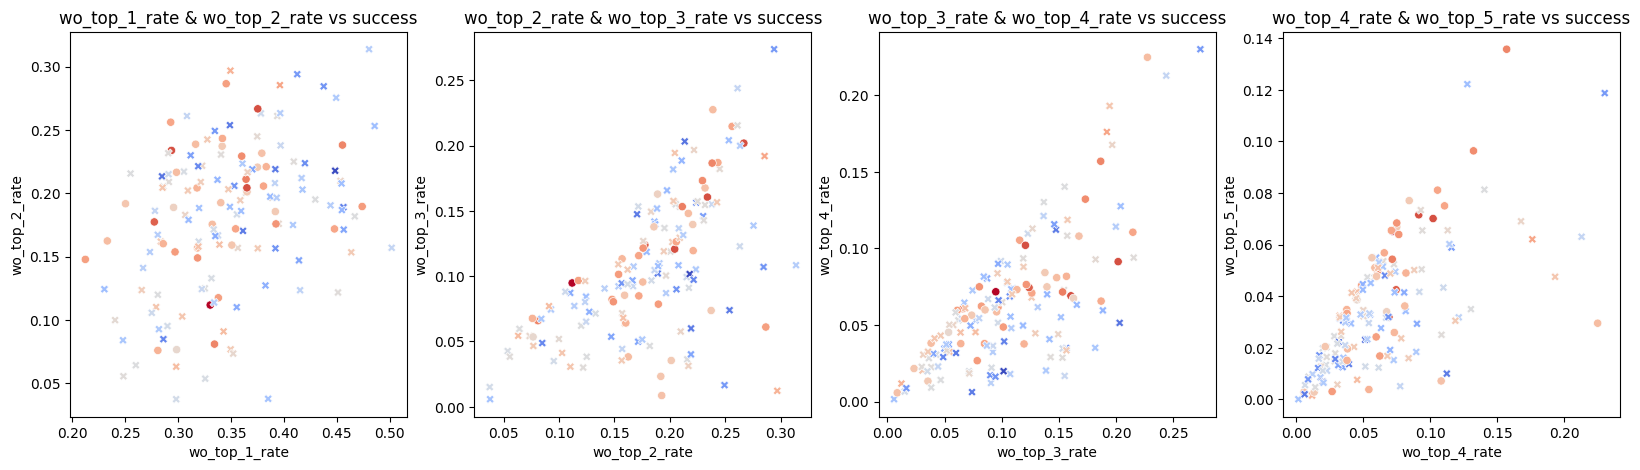

In [163]:
fig, axs = plt.subplots(1,4, figsize = (20,5));
for k in range(1,5):
    first_str = f'wo_top_{k}_rate'
    second_str = f'wo_top_{k+1}_rate'
    s1 = period.top_players_lineups_rate(top_k=k, exclude = True).rename(columns = {'time_share':first_str})
    s2 = period.top_players_lineups_rate(top_k=k+1, exclude = True).rename(columns = {'time_share':second_str})
    _data = s1.merge(s2, right_index = True, left_index = True)
    _data = _data.merge(period.success.swaplevel(0), right_index = True, left_index = True)
    sns.scatterplot(data = _data, x = first_str, y = second_str, **kw_success_plot, ax = axs[k-1], legend = False);
    axs[k-1].set_title(f"{first_str} & {second_str} vs success");


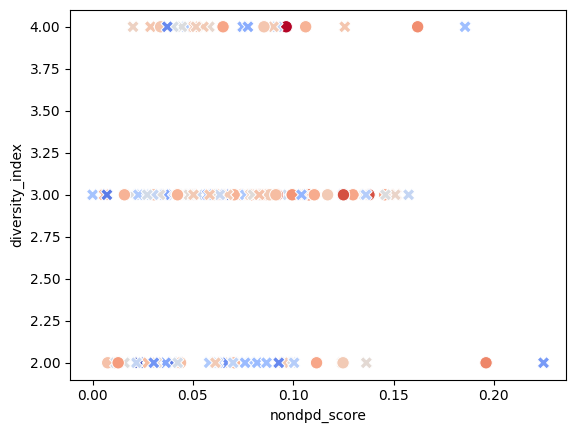

In [164]:
sns.scatterplot(data = period.success, x = 'nondpd_score', y='diversity_index', **kw_success_plot, legend = False, s = 80);

##### Regressions

In [165]:
period.success

,,win_rate,csf,diversity_index,nondpd_score
team,year,,,,
ATL,2015,0.732,1,3,0.074498
DET,2015,0.390,0,4,0.046586
CHI,2015,0.610,1,3,0.030627
CLE,2015,0.646,1,4,0.106198
GSW,2015,0.817,1,3,0.083646
...,...,...,...,...,...
DEN,2019,0.659,1,3,0.110514
ATL,2019,0.354,0,2,0.086716
HOU,2019,0.646,1,3,0.042339


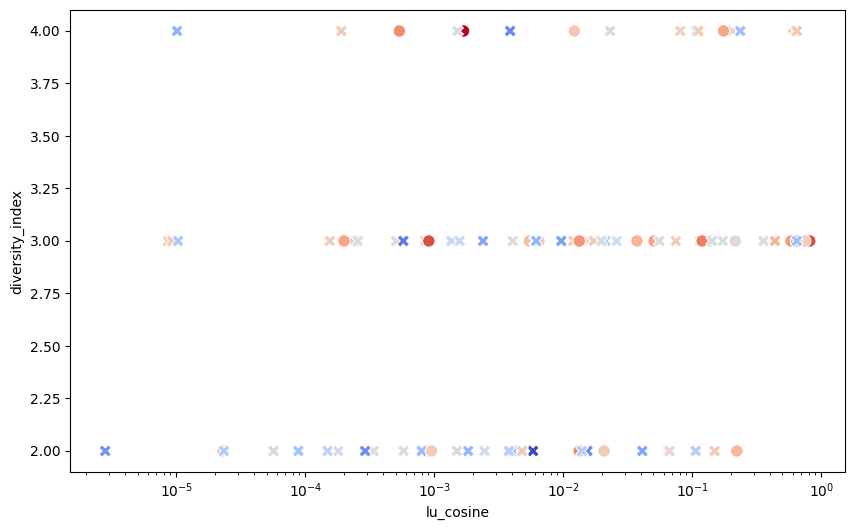

In [166]:
fig, ax = plt.subplots(1,1,figsize = (10,6))

sns.scatterplot(data = period.transitions, x = 'lu_cosine',y = 'diversity_index', hue = 'win_rate', palette='coolwarm', style = 'csf',markers = {0:'X', 1:"o"}, legend = False, ax = ax, s = 80);
ax.set_xscale('log')

In [167]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

features = ['lu_cosine','diversity_index', 'nondpd_score']
# features = [ 'nondpd_score']

Y = period.transitions['win_rate']
X = period.transitions[features]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features, index = X.index)
X = sm.add_constant(X)
Y.shape, X.shape
linreg = OLS(Y,X).fit()
linreg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.375
Date:                Tue, 02 Dec 2025   Prob (F-statistic):            0.00168
Time:                        17:39:36   Log-Likelihood:                 66.538
No. Observations:                 120   AIC:                            -125.1
Df Residuals:                     116   BIC:                            -113.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5000      0.013     38.744      0.000       0.474       0.526
lu_cosine           0.0303      0.013      2.248      0.026       0.004       0.057
diversity_index     0.0250      0.013      1.867      0.064      -0.002       0.051
nondpd_score        0.0228      0.013      1.750      0.083      -0.003       0.049
==============================================================================
Omnibus:                        1.280   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.262
Skew:                          -0.141   Prob(JB):                        0.532
Kurtosis:                       2.584   Cond. No.                         1.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
from statsmodels.discrete.discrete_model import Logit

Y_bin = period.transitions['csf']

logreg = Logit(Y_bin,X).fit()
logreg.summary()


Optimization terminated successfully.
         Current function value: 0.541848
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    csf   No. Observations:                  120
Model:                          Logit   Df Residuals:                      116
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                 0.06564
Time:                        17:39:36   Log-Likelihood:                -65.022
converged:                       True   LL-Null:                       -69.590
Covariance Type:            nonrobust   LLR p-value:                   0.02753
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0781      0.219     -4.918      0.000      -1.508      -0.649
lu_cosine           0.4063      0.205      1.982      0.047       0.005       0.808
diversity_index     0.0698      0.223      0.313      0.754      -0.367       0.507
nondpd_score        0.3785      0.210      1.800      0.072      -0.034       0.791
===================================================================================
"""

### +/-

#### Significant Singletons and Dyads

In [30]:
from statsmodels.regression.linear_model import OLS
t_thres = 2

def pm_ols(period):
    regressions = {}
    players_pm = {}
    significants = {}
    _df = period.data[['pm','team','year'] + [f"rk_{i}" for i in range(5)]].copy()
    for (tm,yr) in period.success.index:
        strid = f"{tm}_{yr}"
        
        _tdf = _df[(_df['team']==tm) & (_df['year']==yr)][['pm'] + [f"rk_{i}" for i in range(5)]].copy()
        rk_max = _tdf['rk_4'].max()
        singletons = range(1,rk_max+1)
        for i in singletons:
            _tdf[i] = (_tdf[[f"rk_{j}" for j in range(5)]]==i).any(axis = 1).astype(int)
        players_pm[strid] = {i : _tdf[_tdf[i]==1]['pm'].sum() for i in singletons}

        dyads = []
        for col_a in singletons :
            for col_b in singletons :       
                if col_a < col_b :
                    dyad = f"{col_a}x{col_b}"
                    dyads.append(dyad)
                    _tdf[dyad] = _tdf[col_a] * _tdf[col_b]
        X_singletons = _tdf[singletons]
        X_dyads = _tdf[dyads]
        Y = _tdf['pm']
        linreg_singletons = OLS(Y,X_singletons).fit()
        linreg_dyads = OLS(Y,X_dyads).fit()
        
        regressions[strid] = {'singletons' : linreg_singletons, 'dyads': linreg_dyads}
        
        significants[strid] = {'singletons' : linreg_singletons.params[linreg_singletons.tvalues.abs() > t_thres], 
                               'dyads': linreg_dyads.params[linreg_dyads.tvalues.abs() > t_thres]}
        
    return regressions, players_pm, significants

reg, ppm, sig = pm_ols(period)

In [31]:
team = 'GSW'
year = 2016
strid = f"{team}_{year}"
inv = {v : k for k,v in period.ordered_rosters[strid].items()}
for k,v in ppm[strid].items():
    print(f"{k:>2} - {inv[k].split(' - ')[0]} : {v}")
print(sig[strid])

 1 - K. Thompson : 764
 2 - S. Curry : 992
 3 - D. Green : 791
 4 - K. Durant : 682
 5 - A. Iguodala : 492
 6 - S. Livingston : 134
 7 - Z. Pachulia : 419
 8 - I. Clark : 54
 9 - P. McCaw : -36
10 - D. West : 119
11 - J. McGee : 314
12 - J. McAdoo : -36
13 - K. Looney : -23
14 - M. Barnes : 36
15 - A. Varejão : -24
16 - D. Jones : -30
17 - B. Weber : -18
{'singletons': 3    3.878062
9   -3.698566
dtype: float64, 'dyads': 1x3     10.530550
1x4      8.136465
1x7      8.394523
2x3      7.635242
3x15   -28.488707
dtype: float64}


In [33]:
significant_df = pd.DataFrame([{'id':k, 
  'single_+':(v['singletons'] > 0).sum(), 
  'single_-':(v['singletons'] < 0).sum(), 
  'dyad_+':(v['dyads'] > 0).sum(), 
  'dyad_-':(v['dyads'] < 0).sum()} for k,v in sig.items()]).set_index('id')
significant_df['n'] = significant_df.sum(axis = 1)
significant_df['net_single'] = significant_df['single_+'] - significant_df['single_-']
significant_df['net_dyad'] = significant_df['dyad_+'] - significant_df['dyad_-']

sdf = period.success.copy()
sdf.index = [f'{tm}_{yr}' for (tm,yr) in sdf.index]
significant_df = significant_df.merge(sdf[['win_rate','csf']], left_index = True, right_index = True )
significant_df.sort_values('win_rate', ascending=False).head(10)

,single_+,single_-,dyad_+,dyad_-,n,net_single,net_dyad,win_rate,csf
GSW_2016,1,1,4,1,7,0,3,0.890,1
GSW_2015,2,0,3,3,8,2,0,0.817,1
SAS_2016,0,1,4,4,9,-1,0,0.817,1
GSW_2017,3,2,3,2,10,1,1,0.817,1
HOU_2018,0,3,1,2,6,-3,-1,0.793,1
SAS_2017,0,0,2,1,3,0,1,0.744,1
MIL_2019,2,0,5,1,8,2,4,0.732,1
ATL_2015,1,0,0,0,1,1,0,0.732,1
TOR_2018,2,1,2,3,8,1,-1,0.720,1
GSW_2018,2,0,2,3,7,2,-1,0.707,1


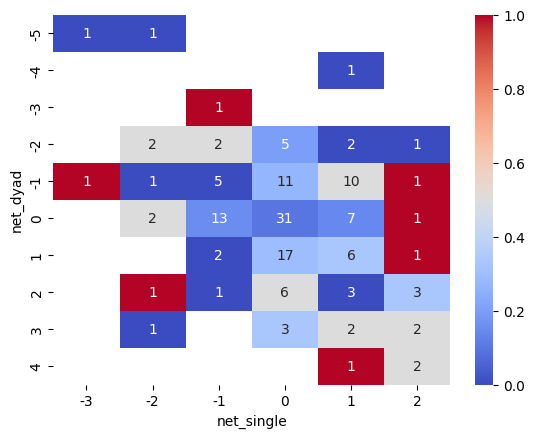

In [46]:
rate_df = significant_df.pivot_table(index = 'net_dyad', columns='net_single', values = 'csf', aggfunc='mean')
count_df = significant_df.pivot_table(index = 'net_dyad', columns='net_single', values = 'csf', aggfunc='count')

sns.heatmap(rate_df, cmap = 'coolwarm', annot= count_df);

In [35]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

classification = False

# X = significant_df[['single_+','single_-','dyad_+','dyad_-']]
X = significant_df[['net_single', 'net_dyad']]
Y = significant_df['csf'] if classification else significant_df['win_rate']
if not classification :
    X = pd.DataFrame(sm.add_constant(X))
reg = Logit(Y,X).fit() if classification else OLS(Y,X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     6.448
Date:                Thu, 11 Dec 2025   Prob (F-statistic):            0.00207
Time:                        09:10:17   Log-Likelihood:                 77.010
No. Observations:                 150   AIC:                            -148.0
Df Residuals:                     147   BIC:                            -139.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4968      0.012     41.421      0.000       0.473       0.520
net_single     0.0356      0.013      2.813      0.006       0.011       0.061
net_dyad       0.0098      0.008      1.191      0.236      -0.006       0.026
==============================================================================
Omnibus:                        0.030   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.985   Jarque-Bera (JB):                0.104
Skew:                          -0.032   Prob(JB):                        0.949
Kurtosis:                       2.888   Cond. No.                         1.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
brackets_df = period.brackets(time_separators=[12,48], pm_separators=[0])
brackets_df = brackets_df.merge(period.success['csf'], right_index = True, left_index = True)
brackets_df

t:[0_12]/pm:[-inf_0]  t:[0_12]/pm:[0_inf]  t:[12_48]/pm:[-inf_0]  \
team year                                                                     
ATL  2015                   189                  136                     26   
     2016                   298                  167                     27   
     2017                   404                  251                     31   
     2018                   388                  237                     40   
     2019                   423                  246                     29   
...                         ...                  ...                    ...   
WAS  2015                   269                  151                     27   
     2016                   206                  120                     21   
     2017                   132                   89                     17   
     2018                   235                  164                     30   
     2019                   280                  162                     31   

           t:[12_48]/pm:[0_inf]  t:[48_inf]/pm:[-inf_0]  \
team year                                                 
ATL  2015                    28                       4   
     2016                    33                       4   
     2017                    22                       6   
     2018                    16                       5   
     2019                    14                       4   
...                         ...                     ...   
WAS  2015                    36                       6   
     2016                    25                       2   
     2017                    19                       6   
     2018                    28                       7   
     2019                    27                       9   

           t:[48_inf]/pm:[0_inf]  csf  
team year                              
ATL  2015                      6    1  
     2016                      4    1  
     2017                      4    0  
     2018                      3    0  
     2019                      3    0  
...                          ...  ...  
WAS  2015                      3    1  
     2016                      6    0  
     2017                      9    1  
     2018                      5    0  
     2019                      4    0  

[150 rows x 7 columns]

In [171]:
from sklearn.preprocessing import MinMaxScaler
Y = brackets_df['csf']
X = brackets_df.drop(columns = 'csf')
colnames = X.columns
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=colnames, index = X.index)
X = sm.add_constant(X)
logreg = Logit(Y,X).fit()
logreg.summary()


Optimization terminated successfully.
         Current function value: 0.459351
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    csf   No. Observations:                  150
Model:                          Logit   Df Residuals:                      143
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.2079
Time:                        17:39:52   Log-Likelihood:                -68.903
converged:                       True   LL-Null:                       -86.987
Covariance Type:            nonrobust   LLR p-value:                 2.556e-06
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.5649      1.516     -1.032      0.302      -4.537       1.407
t:[0_12]/pm:[-inf_0]      -6.5078      2.861     -2.275      0.023     -12.114      -0.901
t:[0_12]/pm:[0_inf]        7.4947      2.869      2.612      0.009       1.871      13.119
t:[12_48]/pm:[-inf_0]     -1.9017      1.315     -1.447      0.148      -4.478       0.675
t:[12_48]/pm:[0_inf]       2.5294      1.019      2.482      0.013       0.532       4.527
t:[48_inf]/pm:[-inf_0]    -1.0705      1.378     -0.777      0.437      -3.771       1.630
t:[48_inf]/pm:[0_inf]     -0.3399      1.441     -0.236      0.814      -3.164       2.484
==========================================================================================
"""

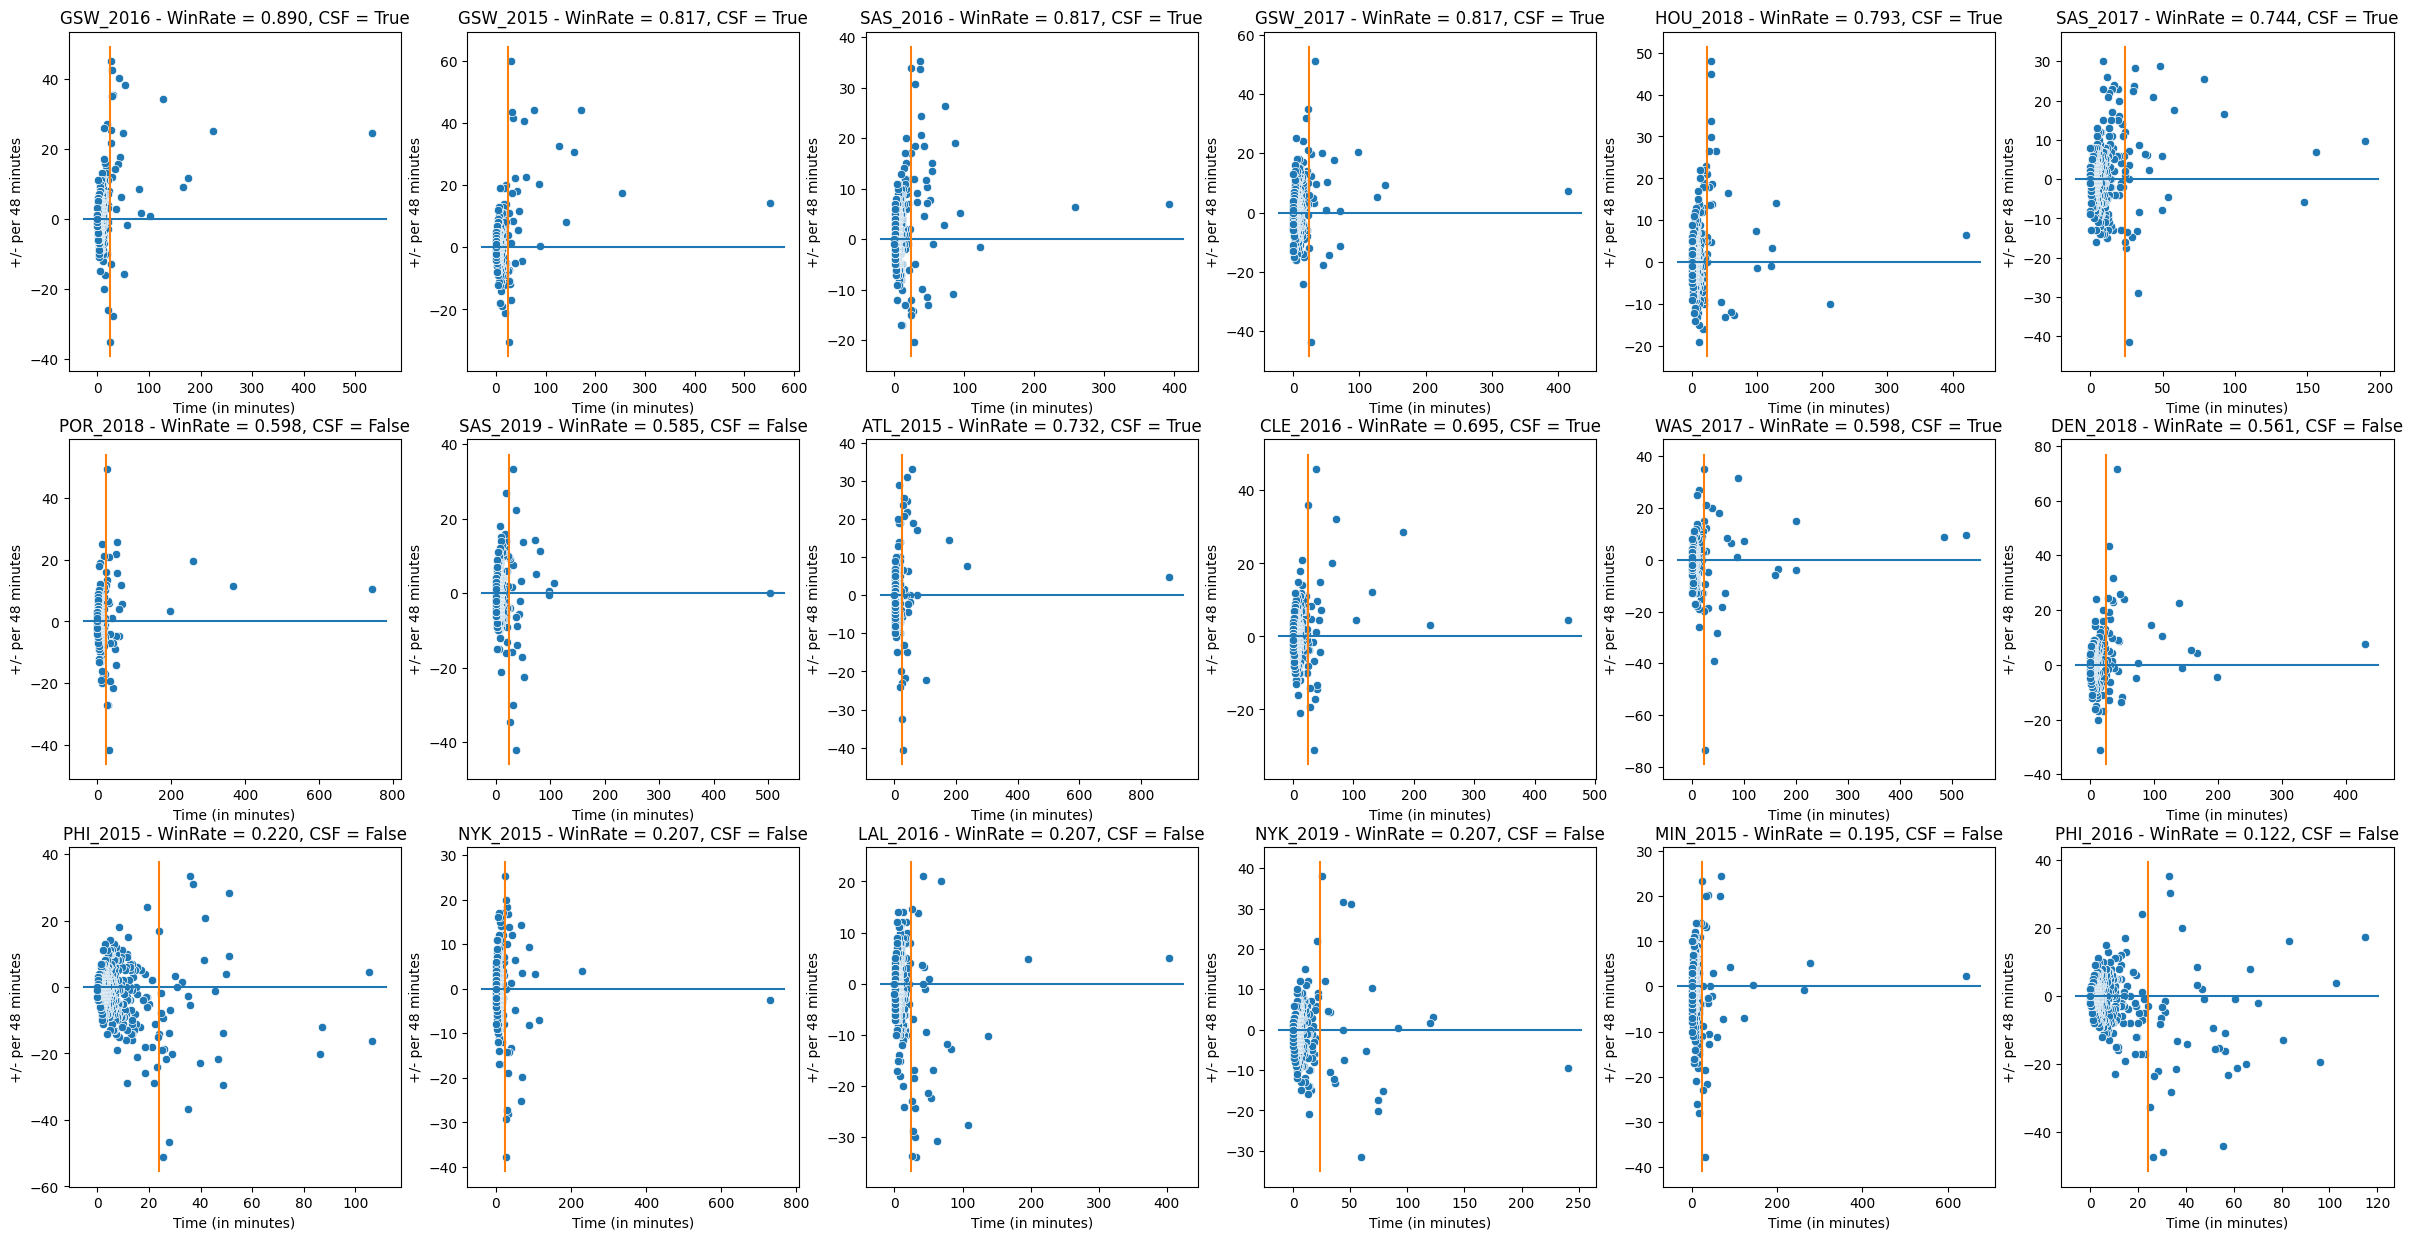

In [127]:
period.illustrate_lineups(k = 6, normalize=True, normalization_threshold=24);

#### Minutes threshold

In [33]:
time_threshold = 48
pm_threshold = 0

ludf['pm_threshold'] = (ludf['pm_per_48min'] > pm_threshold).astype(int)
pmdf = ludf[ludf['time']>time_threshold*60].groupby(['team','year']).agg({'lineup':'count','pm_threshold':'sum','pm_per_48min':'max'})
pmdf['LU_share'] = pmdf['pm_threshold'] / pmdf['lineup'] 
pmdf = pmdf.merge(period.success, right_index=True, left_index=True)
pmdf

lineup  pm_threshold  pm_per_48min  LU_share  win_rate  csf  \
team year                                                                
ATL  2015      10             6     33.132743  0.600000     0.732    1   
     2016       8             4     23.305917  0.500000     0.585    1   
     2017      10             4     39.272727  0.400000     0.524    0   
     2018       8             3      4.600639  0.375000     0.293    0   
     2019       7             3     17.172061  0.428571     0.354    0   
...           ...           ...           ...       ...       ...  ...   
WAS  2015       9             3     17.200191  0.333333     0.561    1   
     2016       8             6     28.021016  0.750000     0.500    0   
     2017      15             9     31.689668  0.600000     0.598    1   
     2018      12             5     24.112525  0.416667     0.524    0   
     2019      13             4      9.554880  0.307692     0.390    0   

           diversity_index  nondpd_score  
team year                                 
ATL  2015                3      0.074498  
     2016                3      0.117139  
     2017                2      0.136431  
     2018                3      0.035757  
     2019                2      0.086716  
...                    ...           ...  
WAS  2015                3      0.084571  
     2016                3      0.145985  
     2017                4      0.033892  
     2018                3      0.048045  
     2019                2      0.058087  

[150 rows x 8 columns]

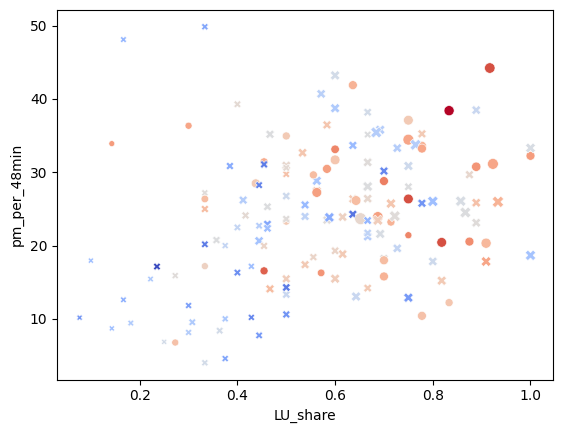

In [39]:
sns.scatterplot(data = pmdf, x = 'LU_share', y = 'pm_per_48min', **kw_success_plot, size = 'pm_threshold', legend = False);

#### Multi-season LU

In [35]:
multi_season_lus = ludf.groupby('lineup').agg({'time':'sum','pm':'sum','year':'count','team':'first','0':'first','1':'first','2':'first','3':'first','4':'first'}).reset_index()
multi_season_lus = multi_season_lus[multi_season_lus['year']>1]
multi_season_lus.sort_values('time',ascending=False).head(20)


,lineup,time,pm,year,team,0,1,2,3,4
19287,B. Beal - bealbr01_J. Wall - walljo01_M. Gorta...,121717,369,3,WAS,B. Beal - bealbr01,J. Wall - walljo01,M. Gortat - gortama01,M. Morris - morrima02,O. Porter - porteot01
17295,A. Wiggins - wiggian01_G. Dieng - dienggo01_K....,91451,9,2,MIN,A. Wiggins - wiggian01,G. Dieng - dienggo01,K. Towns - townska01,R. Rubio - rubiori01,Z. LaVine - lavinza01
964,A. Aminu - aminual01_C. McCollum - mccolcj01_D...,75455,246,3,POR,A. Aminu - aminual01,C. McCollum - mccolcj01,D. Lillard - lillada01,J. Nurkić - nurkiju01,M. Harkless - harklma01
20841,B. Bogdanović - bogdabo02_D. Collison - collid...,75066,83,2,IND,B. Bogdanović - bogdabo02,D. Collison - collida01,M. Turner - turnemy01,T. Young - youngth01,V. Oladipo - oladivi01
57097,G. Harris - harriga01_J. Murray - murraja01_N....,73756,235,3,DEN,G. Harris - harriga01,J. Murray - murraja01,N. Jokić - jokicni01,P. Millsap - millspa01,W. Barton - bartowi01
17384,A. Wiggins - wiggian01_J. Butler - butleji01_J...,70159,153,2,MIN,A. Wiggins - wiggian01,J. Butler - butleji01,J. Teague - teaguje01,K. Towns - townska01,T. Gibson - gibsota01
23074,B. Griffin - griffbl01_C. Paul - paulch01_D. J...,68654,375,2,LAC,B. Griffin - griffbl01,C. Paul - paulch01,D. Jordan - jordade01,J. Redick - redicjj01,L. Mbah a Moute - mbahalu01
43676,D. Favors - favorde01_D. Mitchell - mitchdo01_...,57320,177,2,UTA,D. Favors - favorde01,D. Mitchell - mitchdo01,J. Ingles - inglejo01,R. Gobert - goberru01,R. Rubio - rubiori01
45946,D. Green - greendr01_K. Durant - duranke01_K. ...,56791,335,2,GSW,D. Green - greendr01,K. Durant - duranke01,K. Thompson - thompkl01,S. Curry - curryst01,Z. Pachulia - pachuza01
8169,A. Gordon - gordoaa01_D. Augustin - augusdj01_...,56496,63,3,ORL,A. Gordon - gordoaa01,D. Augustin - augusdj01,E. Fournier - fournev01,J. Isaac - isaacjo01,N. Vučević - vucevni01


In [36]:
multi_season_lus.groupby('team').agg({'year':'max'}).sort_values('year',ascending=False)

,year
team,
CHA,4
ORL,4
POR,4
DET,3
GSW,3
CLE,3
MIL,3
UTA,3
TOR,3


#### Most impacting LU

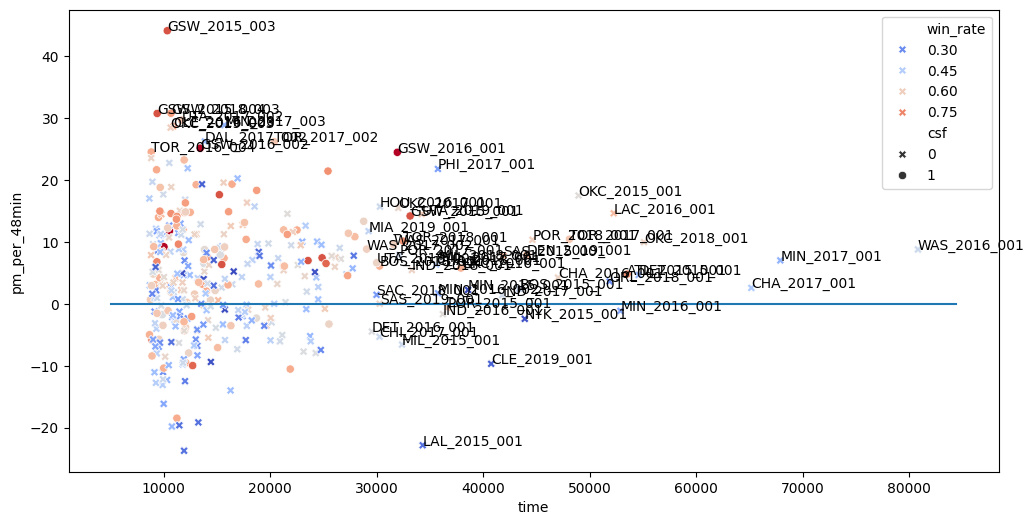

In [ ]:
time_threshold = 144 # in minutes
annot_threshold_time = 480 # 5 games played together
annot_threshold_abs_pm = 24
ludf_considered = ludf[ludf['time']>= time_threshold*60]

fig, ax = plt.subplots(1,1,figsize = (12,6));
sns.scatterplot(data=ludf_considered, x = 'time', y = 'pm_per_48min', ax = ax, **kw_success_plot);
plt.plot(ax.get_xlim(), [0,0])
for index, row in ludf_considered.iterrows():
    if row['time'] >= annot_threshold_time * 60 or np.abs(row['pm_per_48min']) > annot_threshold_abs_pm:
        ax.text(row['time'],row['pm_per_48min'],row['id']); 

In [38]:
ludf_considered.sort_values('pm_per_48min', ascending = False).head(20)

,id,lineup,time,pm,pm_per_48min,team,year,win_rate,csf,0,...,4,relative_time,rk_0,rk_1,rk_2,rk_3,rk_4,rk_id,use_id,pm_threshold
1452,GSW_2015_003,A. Iguodala - iguodan01_D. Green - greendr01_H...,10326,158,44.067403,GSW,2015,0.817,1,A. Iguodala - iguodan01,...,S. Curry - curryst01,0.043285,1,2,3,4,5,1_2_3_4_5,3,1
40495,GSW_2018_003,A. Iguodala - iguodan01_D. Green - greendr01_K...,10676,114,30.753091,GSW,2018,0.707,1,A. Iguodala - iguodan01,...,S. Curry - curryst01,0.044978,1,2,3,4,5,1_2_3_4_5,3,1
1453,GSW_2015_004,A. Bogut - bogutan01_A. Iguodala - iguodan01_D...,9377,100,30.713448,GSW,2015,0.817,1,A. Bogut - bogutan01,...,S. Curry - curryst01,0.039307,1,2,3,5,7,1_2_3_5_7,4,1
33820,UTA_2017_002,D. Mitchell - mitchdo01_J. Crowder - crowdja01...,11659,120,29.642336,UTA,2017,0.622,1,D. Mitchell - mitchdo01,...,R. Rubio - rubiori01,0.049182,1,2,3,5,12,1_2_3_5_12,2,1
35266,MIN_2017_003,A. Wiggins - wiggian01_J. Butler - butleji01_K...,15681,157,28.834896,MIN,2017,0.378,0,A. Wiggins - wiggian01,...,T. Jones - jonesty01,0.065981,1,2,3,5,7,1_2_3_5_7,3,1
12761,CLE_2016_003,D. Liggins - liggide01_K. Irving - irvinky01_K...,10879,108,28.590863,CLE,2016,0.695,1,D. Liggins - liggide01,...,T. Thompson - thomptr01,0.045603,1,2,3,5,10,1_2_3_5_10,3,1
63720,OKC_2019_003,C. Paul - paulch01_D. Gallinari - gallida01_D....,10640,105,28.421053,OKC,2019,0.598,0,C. Paul - paulch01,...,S. Gilgeous-Alexander - gilgesh01,0.050943,1,2,3,4,5,1_2_3_4_5,3,1
32680,DAL_2017_002,D. Harris - harride01_D. Nowitzki - nowitdi01_...,13847,126,26.206398,DAL,2017,0.402,0,D. Harris - harride01,...,Y. Ferrell - ferreyo01,0.058338,2,5,6,7,9,2_5_6_7_9,2,1
36927,TOR_2017_002,C. Miles - milescj01_D. Wright - wrighde01_F. ...,20375,185,26.149693,TOR,2017,0.622,1,C. Miles - milescj01,...,P. Siakam - siakapa01,0.085732,5,6,7,9,10,5_6_7_9_10,2,1
14525,GSW_2016_002,A. Iguodala - iguodan01_D. Green - greendr01_K...,13420,117,25.108793,GSW,2016,0.890,1,A. Iguodala - iguodan01,...,S. Curry - curryst01,0.056539,1,2,3,4,5,1_2_3_4_5,2,1


# Season class

In [48]:
s = Season(2015)


Loading play-by-play data COMPLETED
Processing play-by-play data COMPLETED
Attempting to load lineups statistics SUCCEEDED
Processing lineups statistics COMPLETED
